In [1]:
import numpy as np
import pandas as pd
from utils import read_q_mat, read_a_mat
import scipy.io
from sim import (
    model_setup,
    sim_hb,
    std_operating_policy,
    max_release,
    min_release,
    level_to_storage,
)
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import OF_flood, OF_hydro
import os
from process_policy import find_best_policy, plot_policy, process_policy, plot_policy_ts
from itertools import product

from dotenv import load_dotenv


import warnings

warnings.filterwarnings("ignore")

In [2]:
sns.set_context("paper", font_scale=1.5)
plt.rcParams["figure.figsize"] = [12, 8]

# Current performance quantification

## Setting up the model


In [3]:
start_date = "1994-11-01"
end_date = "2007-01-01"
q_vu = "/Users/cooper/Desktop/optimal-wat-allocation/data/q_vuquang.mat"
q_ye = "/Users/cooper/Desktop/optimal-wat-allocation/data/q_yenbai.mat"
a = "/Users/cooper/Desktop/optimal-wat-allocation/data/a_hoabinh_K.mat"

qq, sys_params = model_setup(
    ini_date=start_date,
    fin_date=end_date,
    path_a_hoabinh_K=a,
    path_q_vuquang=q_vu,
    path_q_yenbai=q_ye,
)

## Plotting the current control policy


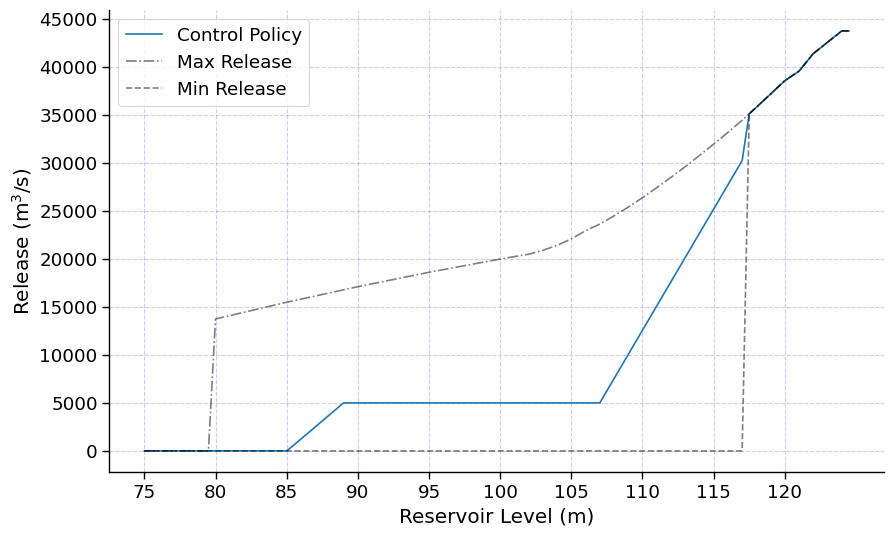

In [4]:
control_policy = (89, 107, 1.57, 1.5704, 5000)


plot_policy(
    policies=[control_policy],
    sys_params=sys_params,
    names=["Control Policy"],
    output_destination="/Users/cooper/Desktop/optimal-wat-allocation/images/control_policy.png",
)

## Plotting the time series of simulated reservoir level, release, and water level in Hanoi for the period 1995-2006.


In [5]:
control_policy_simul = process_policy(
    path_to_policy="/Users/cooper/Desktop/optimal-wat-allocation/data/simHB_output.csv",
    start_date=start_date,
    end_date=end_date,
)

control_policy_simul = control_policy_simul["1995":"2006"]
control_policy_simul

,ReservoirLevel,ReleaseDecision,Release,WaterLevelHanoi
Date,,,,
1995-01-01,85.643921,785.551161,804.235152,3.415327
1995-01-02,85.614685,748.837769,785.551161,3.411999
1995-01-03,85.606837,738.982871,748.837769,3.348751
1995-01-04,85.626696,763.921157,738.982871,3.364501
1995-01-05,85.741300,907.836437,763.921157,3.667345
...,...,...,...,...
2006-12-27,85.419935,504.277673,514.862006,2.051027
2006-12-28,85.411271,493.397313,504.277673,2.040744
2006-12-29,85.390629,467.476096,493.397313,2.148142


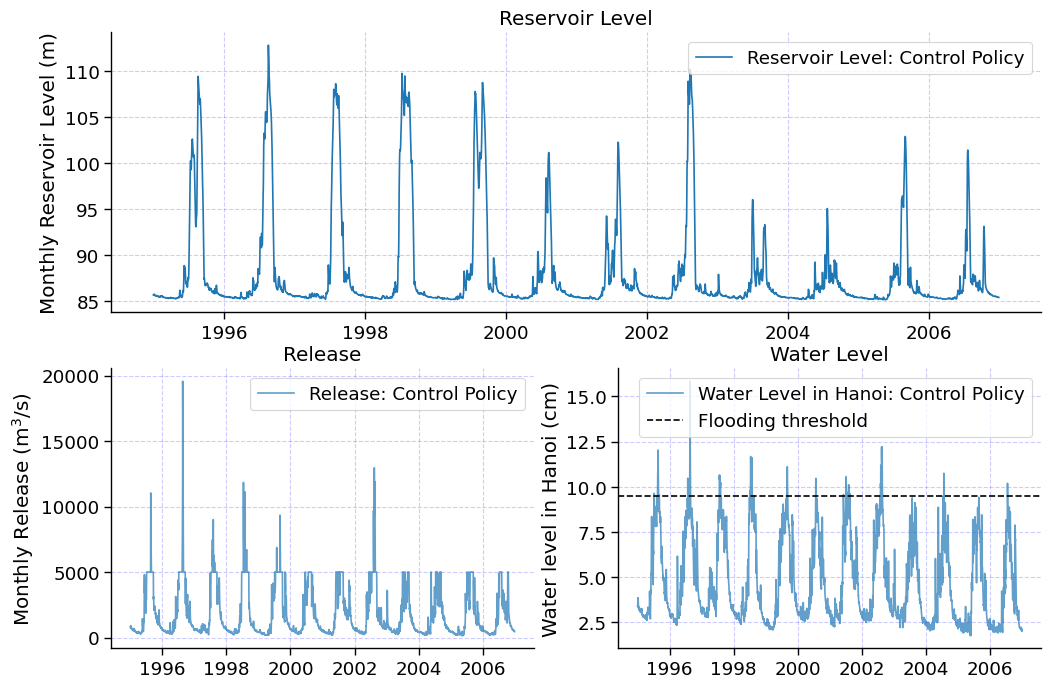

In [6]:
policy1 = plot_policy_ts(
    [control_policy_simul],
    ["Control Policy"],
    "/Users/cooper/Desktop/optimal-wat-allocation/images/control_policy_TS.png",
)

## Computing the current performance in the two operating objectives


In [7]:
j_flood = OF_flood(control_policy_simul["WaterLevelHanoi"] * 100)

j_hydro = OF_hydro(
    qq["q_Da"]["1995":"2006"],
    control_policy_simul["Release"],
    control_policy_simul["ReservoirLevel"],
)

print(f"j_flood: {j_flood} [cm2]")
print(f"j_hydro: {j_hydro} [GWh/d]")

j_flood: 525.77 [cm2]
j_hydro: 16.73 [GWh/d]


# Exhaustive optimisation on a Finite Policy Parameters Set

## Creating the set of policy parameters


In [8]:
h1 = 89
h2_values = [100, 105, 110, 115]
m1 = 1.57
m2_values = [1.56, 1.565, 1.57]
w_values = [500, 1000, 1500, 2000, 3000, 8000, 13000]

combinations = list(product([h1], h2_values, [m1], m2_values, w_values))


policies_df = pd.DataFrame(combinations, columns=["h1", "h2", "m1", "m2", "w"])

policies_df["Policy"] = policies_df.apply(tuple, axis=1)
policies_df = policies_df[["Policy"]]

policies_df

,Policy
0,"(89.0, 100.0, 1.57, 1.56, 500.0)"
1,"(89.0, 100.0, 1.57, 1.56, 1000.0)"
2,"(89.0, 100.0, 1.57, 1.56, 1500.0)"
3,"(89.0, 100.0, 1.57, 1.56, 2000.0)"
4,"(89.0, 100.0, 1.57, 1.56, 3000.0)"
...,...
79,"(89.0, 115.0, 1.57, 1.57, 1500.0)"
80,"(89.0, 115.0, 1.57, 1.57, 2000.0)"
81,"(89.0, 115.0, 1.57, 1.57, 3000.0)"
82,"(89.0, 115.0, 1.57, 1.57, 8000.0)"


## Finding the best policy for hydropower, the best for flood control, and the best compromise


In [9]:
compromise = find_best_policy(
    criteria="compromise",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

compromise_policy = policies_df.iloc[compromise["policy"] - 1]["Policy"]


flood = find_best_policy(
    criteria="flood",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

flood_policy = policies_df.iloc[flood["policy"] - 1]["Policy"]

hydro = find_best_policy(
    criteria="hydro",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

hydro_policy = policies_df.iloc[hydro["policy"] - 1]["Policy"]

In [10]:
compromise_policy

(89.0, 110.0, 1.57, 1.56, 2000.0)

In [11]:
compromise

{'policy': 46, 'OF_flood': 670.55, 'OF_hydro': 23.2, 'criteria': 'compromise'}

## Getting the simulation time series


In [12]:
compromise_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{compromise['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

compromise_policy_simul = compromise_policy_simul["1995":"2006"]

flood_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{flood['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

flood_policy_simul = flood_policy_simul["1995":"2006"]

hydro_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{hydro['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

hydro_policy_simul = hydro_policy_simul["1995":"2006"]

## Plotting all three policies and the time series of simulated reservoir level, release, and water level in Hanoi for the period 1995-2006.


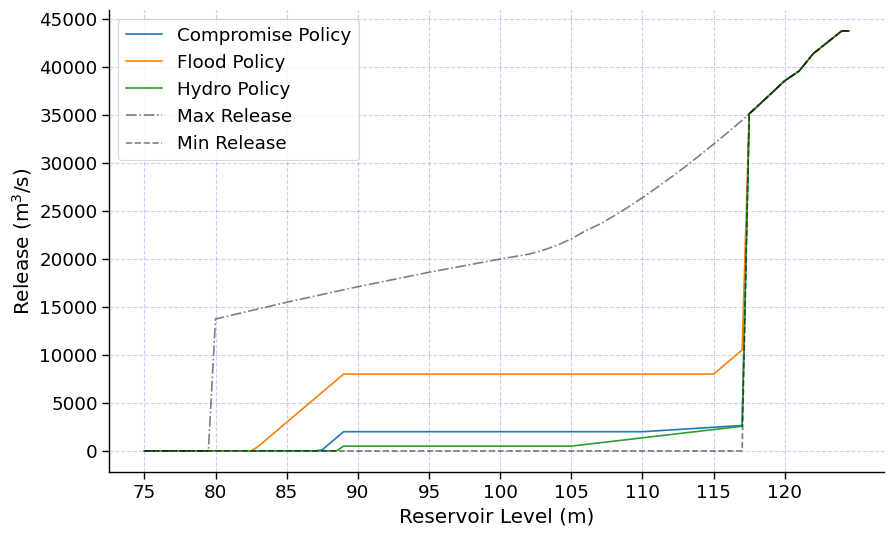

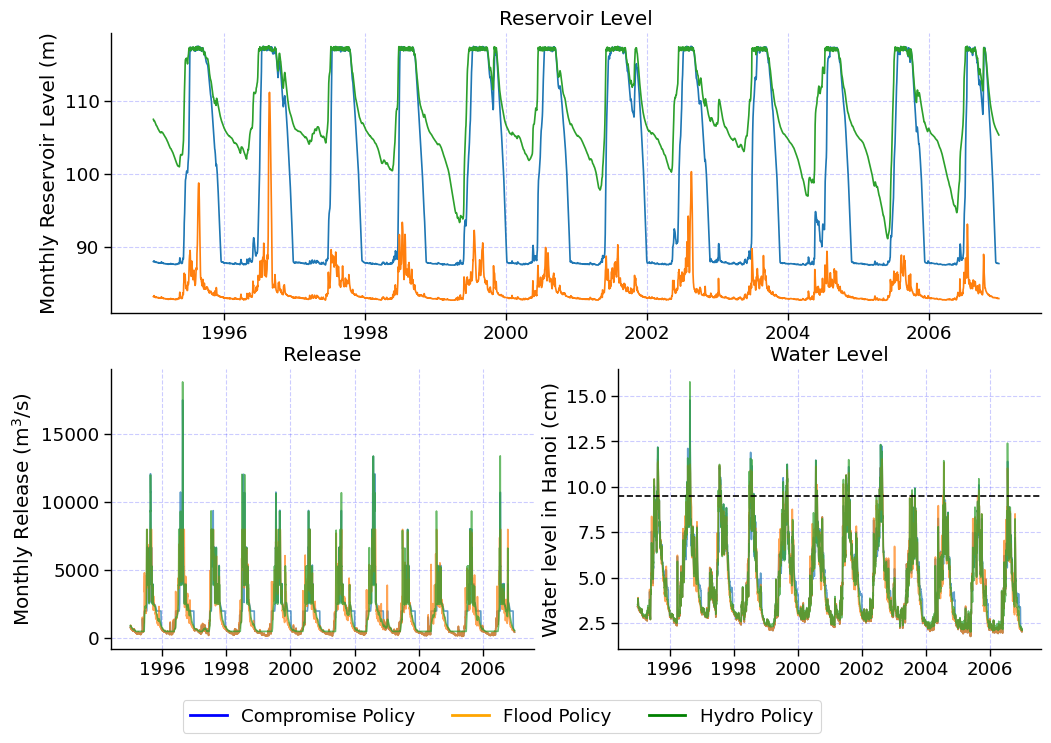

In [13]:
plot_policy(
    policies=[compromise_policy, flood_policy, hydro_policy],
    sys_params=sys_params,
    output_destination="/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_policies.png",
    names=["Compromise Policy", "Flood Policy", "Hydro Policy"],
)

plot_policy_ts(
    [compromise_policy_simul, flood_policy_simul, hydro_policy_simul],
    ["Compromise Policy", "Flood Policy", "Hydro Policy"],
    "/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_TS.png",
)

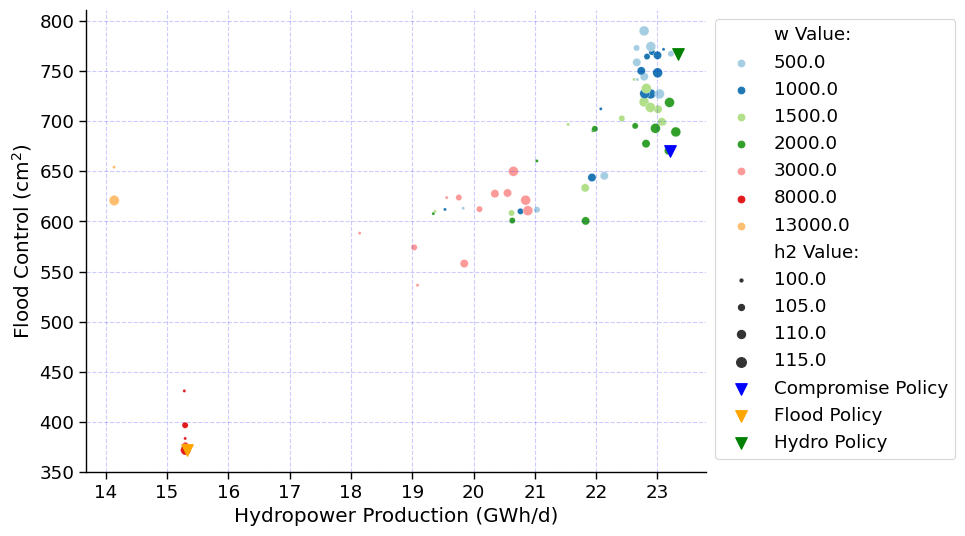

In [14]:
df = pd.read_csv(
    "/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_summary.csv"
)

# Process data
df = df.iloc[:, -2:].reset_index(drop=True)
merge_df = df.merge(policies_df, left_index=True, right_index=True)
merge_df["h1"] = merge_df["Policy"].apply(lambda x: x[0])
merge_df["h2"] = merge_df["Policy"].apply(lambda x: x[1])
merge_df["m1"] = merge_df["Policy"].apply(lambda x: x[2])
merge_df["m2"] = merge_df["Policy"].apply(lambda x: x[3])
merge_df["w"] = merge_df["Policy"].apply(lambda x: x[-1])

# Create dummy columns for example
merge_df["w Value:"] = merge_df["w"]
merge_df["h2 Value:"] = merge_df["h2"]
merge_df["m2 Value:"] = merge_df["m2"]

output_destination = "/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_policies_scatter.png"

hue_order = merge_df["w Value:"].unique()
custom_palette = dict(zip(hue_order, sns.color_palette("Paired", len(hue_order))))

# Plot
plt.figure(figsize=(8, 6))

scatter = sns.scatterplot(
    data=merge_df,
    x="Hydropower Objective",
    y="Flood Objective",
    hue="w Value:",
    size="h2 Value:",
    # style="m2 Value",
    palette=custom_palette,
    sizes=(5, 50),
    legend="full",
)

# Adding specific policies
plt.scatter(
    compromise["OF_hydro"],
    compromise["OF_flood"],
    c="#0000FF",
    s=70,
    label="Compromise Policy",
    marker="v",
)
plt.scatter(
    flood["OF_hydro"],
    flood["OF_flood"],
    c="orange",
    s=70,
    label="Flood Policy",
    marker="v",
)
plt.scatter(
    hydro["OF_hydro"],
    hydro["OF_flood"],
    c="green",
    s=70,
    label="Hydro Policy",
    marker="v",
)

# Labels and Legend
plt.xlabel("Hydropower Production (GWh/d)")
plt.ylabel("Flood Control (cm$^2$)")
sns.despine()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.grid(alpha=0.2, linestyle="--", color="#0000FF")

# Axis ticks
plt.xticks(range(14, 24, 1))
plt.yticks(range(350, 850, 50))
plt.savefig(output_destination, bbox_inches="tight", dpi=300)
plt.show()

## Optimization via Evolutionary Multi-Objective Direct Policy Search


In [15]:
def load_and_concat_data(
    filenames: list[str], columns: list[str], folder_path: str
) -> pd.DataFrame:
    """
    Load CSV files, concatenate them into a single DataFrame, and drop duplicates.

    Parameters:
    - filenames: list of filenames to load
    - columns: list of column names
    - folder_path: path to folder containing CSV files

    Returns:
    - combined_data: concatenated DataFrame
    """
    combined_data = pd.DataFrame(columns=columns)

    for filename in filenames:
        df = pd.read_csv(os.path.join(folder_path, f"{filename}.csv"), header=None)
        df.columns = columns

        combined_data = pd.concat([combined_data, df]).reset_index(drop=True)
        combined_data.drop_duplicates(
            inplace=True, subset=["h2", "m2", "w", "OF_flood", "OF_hydro"]
        )

    return combined_data

In [16]:
chrfs = ["chrf", "chrf1", "chrf2", "chrf3"]
columns = ["h2", "m2", "w", "OF_flood", "OF_hydro", "output1", "output3"]

load_dotenv()

workspace = os.getenv("WORKSPACE")
genoptdata = os.getenv("GENOPTDATA")

path_to_folder = os.path.join(workspace, genoptdata)

gen_opt_policies = load_and_concat_data(chrfs, columns, path_to_folder)
gen_opt_policies["OF_hydro"] = -gen_opt_policies["OF_hydro"]

In [17]:
gen_opt_policies.head()

,h2,m2,w,OF_flood,OF_hydro,output1,output3
0,113.88,1.5604,6012.9,206.25,16.158,1,inf
1,111.80,1.5600,1928.3,664.70,23.312,1,inf
2,103.72,1.5694,500.0,542.23,21.184,1,0.56915
3,112.27,1.5643,1899.5,657.20,23.204,1,0.54393
4,106.20,1.5644,3681.4,517.15,18.401,1,0.44253


In [18]:
chros = ["chr0", "chr01", "chr02", "chr03"]
columns = ["h2", "m2", "w", "OF_flood", "OF_hydro"]

gen_init_policies = load_and_concat_data(chros, columns, path_to_folder)
gen_init_policies["OF_hydro"] = -gen_init_policies["OF_hydro"]

## Plot all 'suboptimal' policies and and the pareto front


In [19]:
def find_pareto_frontier(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    """
    Find the Pareto frontier of a DataFrame with two objectives.

    Parameters:
    - df: DataFrame with two objectives
    - x: name of the first objective
    - y: name of the second objective

    Returns:
    - pareto_frontier: DataFrame containing the Pareto frontier
    """
    pareto_frontier = []

    for i, row in df.iterrows():
        if not any((df[x] > row[x]) & (-df[y] > -row[y])):
            pareto_frontier.append(row)

    pareto_frontier = pd.DataFrame(pareto_frontier, columns=df.columns)
    return pareto_frontier


pareto_frontier = find_pareto_frontier(gen_opt_policies, "OF_hydro", "OF_flood")


In [20]:
compromise_range = {
    'OF_flood': (300, 600),
    'OF_hydro': (18, 21),
}

# Randomly select one policy from the Pareto frontier within the compromise range
compromise_policies = pareto_frontier[
    (pareto_frontier["OF_flood"] > compromise_range["OF_flood"][0])
    & (pareto_frontier["OF_flood"] < compromise_range["OF_flood"][1])
    & (pareto_frontier["OF_hydro"] > compromise_range["OF_hydro"][0])
    & (pareto_frontier["OF_hydro"] < compromise_range["OF_hydro"][1])
]

compromise_policies

,h2,m2,w,OF_flood,OF_hydro,output1,output3
5,103.70,1.5693,1062.70,524.12,20.895,1,0.407790
63,102.09,1.5689,952.77,496.47,20.778,1,1.067500
69,101.80,1.5687,896.39,515.53,20.860,1,0.085018
73,102.13,1.5688,908.05,530.01,20.907,1,0.066234


## Finding top 5 best performing policies

In [21]:
top_flood = pareto_frontier.sort_values("OF_flood", ascending=True).head(5).drop(['output1', 'output3'], axis=1)
top_hydro = pareto_frontier.sort_values("OF_hydro", ascending=False).head(5).drop(['output1', 'output3'], axis=1)

In [22]:
top_flood

,h2,m2,w,OF_flood,OF_hydro
0,113.88,1.5604,6012.9,206.25,16.158
41,113.19,1.5634,5991.8,208.24,16.169
17,114.23,1.5604,5827.7,214.31,16.274
74,114.05,1.5621,5655.7,217.55,16.396
75,114.12,1.5621,5599.9,222.22,16.440


In [23]:
top_hydro

,h2,m2,w,OF_flood,OF_hydro
61,115.00,1.5624,2162.5,705.32,23.398
68,114.93,1.5624,2225.8,657.29,23.396
65,115.00,1.5624,2170.0,649.25,23.383
29,112.79,1.5695,2061.3,644.58,22.619
64,111.03,1.5619,2498.5,635.54,22.339


In [24]:
min_flood = pareto_frontier["OF_flood"].min()
min_flood

206.25

In [25]:
max_hydro = pareto_frontier["OF_hydro"].max()
max_hydro

23.398

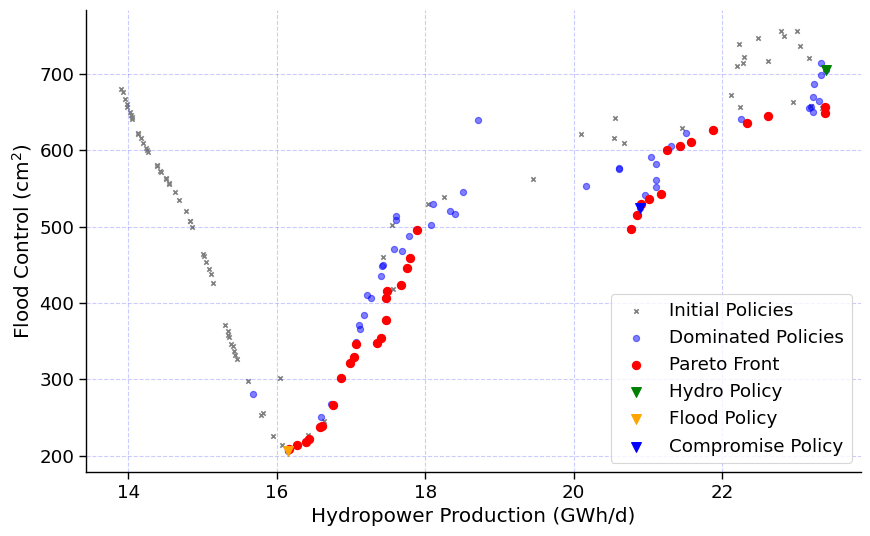

In [26]:
hydro_pareto = (23.398, 705.32)
flood_pareto = (16.158, 206.25)
compromise_pareto = (20.895, 524.12)

pareto_selections = [hydro_pareto, flood_pareto, compromise_pareto]
pareto_names = ["Hydro Policy", "Flood Policy", "Compromise Policy"]
paret_colors = ["green", "orange", "blue"]

pareto_frontier = pareto_frontier[
    ~pareto_frontier.apply(
        lambda x: (x["OF_hydro"], x["OF_flood"]) in pareto_selections, axis=1
    )
]

plt.figure(figsize=(10, 6))
plt.scatter(
    gen_init_policies["OF_hydro"],
    gen_init_policies["OF_flood"],
    c="gray",
    s=10,
    alpha=1,
    label="Initial Policies",
    marker="x",
)

plt.scatter(
    gen_opt_policies["OF_hydro"],
    gen_opt_policies["OF_flood"],
    c="blue",
    s=20,
    alpha=0.5,
    label="Dominated Policies",
)

plt.scatter(
    pareto_frontier["OF_hydro"],
    pareto_frontier["OF_flood"],
    c="red",
    s=35,
    label="Pareto Front",
)

for i, (x, y) in enumerate(pareto_selections):
    plt.scatter(
        x,
        y,
        c=paret_colors[i],
        s=50,
        label=pareto_names[i],
        marker="v",
    )


plt.xlabel("Hydropower Production (GWh/d)")
plt.ylabel("Flood Control (cm$^2$)")
sns.despine()
plt.legend()
plt.grid(alpha=0.2, linestyle="--", color="#0000FF")
plt.savefig(
    "/Users/cooper/Desktop/optimal-wat-allocation/images/pareto_frontier.png",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

In [27]:
hydro_pareto_simul = process_policy(
    path_to_policy='/Users/cooper/Desktop/optimal-wat-allocation/data/policy_paretohydro.csv',
    start_date=start_date,
    end_date=end_date,
)

hydro_pareto_simul = hydro_pareto_simul["1995":"2006"]

flood_pareto_simul = process_policy(
    path_to_policy='/Users/cooper/Desktop/optimal-wat-allocation/data/policy_paretofloodcontrol.csv',
    start_date=start_date,
    end_date=end_date,
)

hydro_pareto_simul = hydro_pareto_simul["1995":"2006"]

compromise_pareto_simul = process_policy(
    path_to_policy='/Users/cooper/Desktop/optimal-wat-allocation/data/policy_paretocompromise.csv',
    start_date=start_date,
    end_date=end_date,
)

hydro_pareto_simul = hydro_pareto_simul["1995":"2006"]


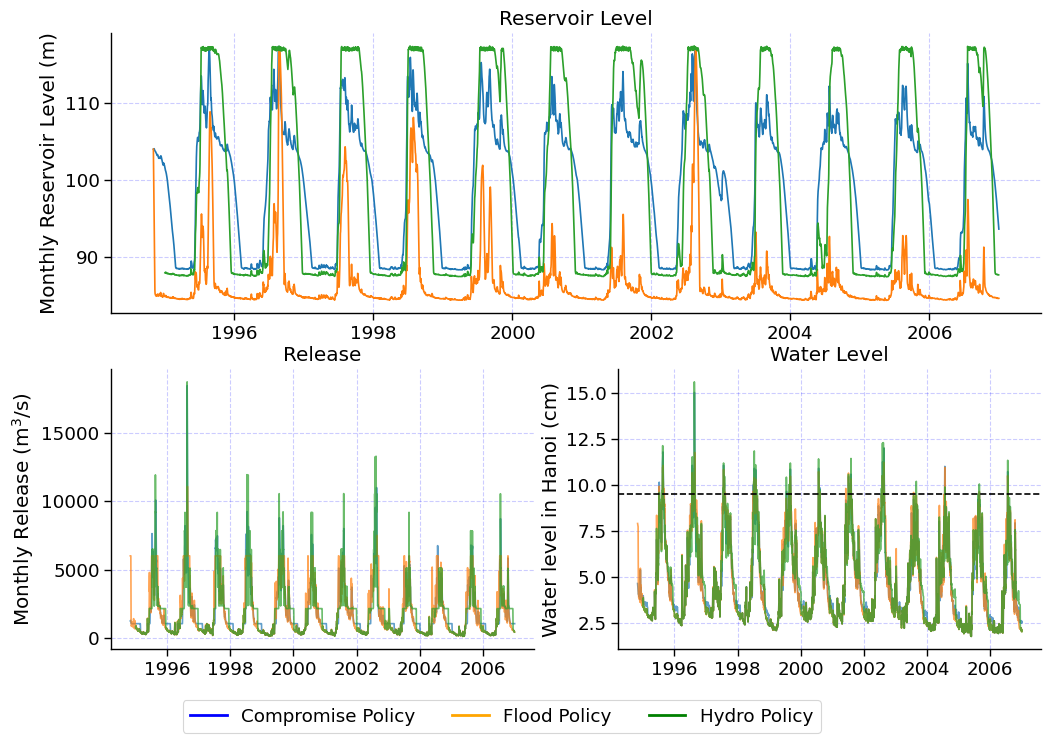

In [28]:
plot_policy_ts(
    [compromise_pareto_simul, flood_pareto_simul, hydro_pareto_simul],
    ["Compromise Policy", "Flood Policy", "Hydro Policy"],
    "/Users/cooper/Desktop/optimal-wat-allocation/images/pareto_compromise_flood_hydro_TS.png",
)

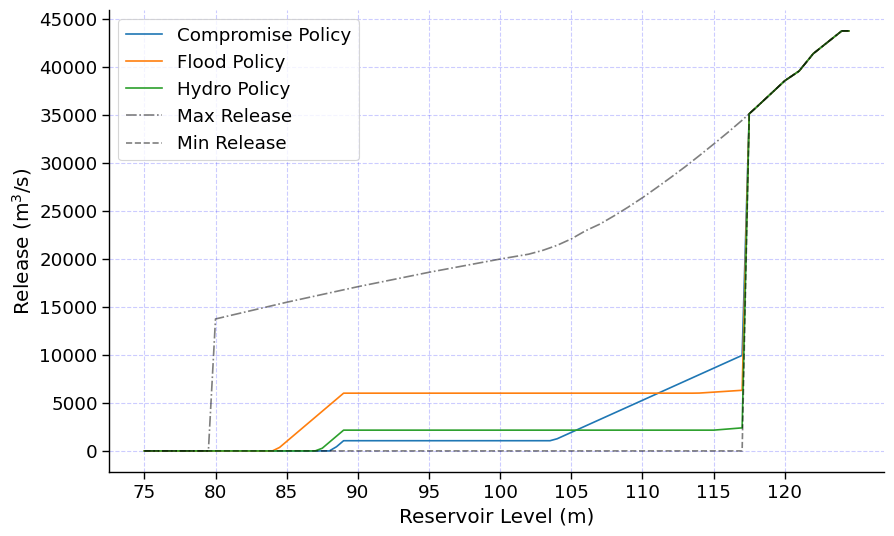

In [29]:
policy_pareto_HP = (89.0, 115.00, 1.57, 1.5624, 2162.5)
policy_pareto_FC = (89.0, 113.88, 1.57, 1.5604, 6012.9)
policy_pareto_Compromise = (89.0, 103.70, 1.57, 1.5693, 1062.70)

plot_policy(
    policies=[policy_pareto_Compromise, policy_pareto_FC, policy_pareto_HP],
    sys_params=sys_params,
    output_destination="/Users/cooper/Desktop/optimal-wat-allocation/images/pareto_compromise_flood_hydro_policies.png",
    names=["Compromise Policy", "Flood Policy", "Hydro Policy"],
)
